In [1]:
!pip install -q darts

     |████████████████████████████████| 290 kB 8.2 MB/s 
     |████████████████████████████████| 9.8 MB 39.3 MB/s 
     |████████████████████████████████| 1.4 MB 32.3 MB/s 
     |████████████████████████████████| 155 kB 81.8 MB/s 
     |████████████████████████████████| 791 kB 67.1 MB/s 
     |████████████████████████████████| 11.2 MB 15.1 MB/s 
     |████████████████████████████████| 177 kB 31.0 MB/s 
     |████████████████████████████████| 65 kB 5.5 MB/s 
     |████████████████████████████████| 374 kB 39.1 MB/s 
     |████████████████████████████████| 884 kB 72.4 MB/s 
     |████████████████████████████████| 49 kB 6.8 MB/s 
     |████████████████████████████████| 216 kB 71.6 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyter-console 5.2.0 requires prompt-toolkit<2.0.0,>=1.0.0, but you have prompt-toolkit 3.0.24 which is incompatible.
google-colab 1

In [2]:
!pip install -q matplotlib==3.1.3

     |████████████████████████████████| 13.1 MB 6.5 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fbprophet 0.7.1 requires cmdstanpy==0.9.5, but you have cmdstanpy 0.9.68 which is incompatible.
darts 0.14.0 requires matplotlib>=3.3.0, but you have matplotlib 3.1.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [3]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.models import RNNModel, TCNModel, TransformerModel, NBEATSModel, BlockRNNModel
from darts.metrics import mape, smape
from darts.dataprocessing.transformers import Scaler
import sklearn.preprocessing as preprocessing

In [43]:
df = pd.read_csv('Electricity_demand.csv')

In [44]:
df.head(5)

,date,demand,RRP,demand_pos_RRP,RRP_positive,demand_neg_RRP,RRP_negative,frac_at_neg_RRP,min_temperature,max_temperature,solar_exposure,rainfall,school_day,holiday
0,2015-01-01,99635.030,25.633696,97319.240,26.415953,2315.790,-7.240000,0.020833,13.3,26.9,23.6,0.0,N,Y
1,2015-01-02,129606.010,33.138988,121082.015,38.837661,8523.995,-47.809777,0.062500,15.4,38.8,26.8,0.0,N,N
2,2015-01-03,142300.540,34.564855,142300.540,34.564855,0.000,0.000000,0.000000,20.0,38.2,26.5,0.0,N,N
3,2015-01-04,104330.715,25.005560,104330.715,25.005560,0.000,0.000000,0.000000,16.3,21.4,25.2,4.2,N,N
4,2015-01-05,118132.200,26.724176,118132.200,26.724176,0.000,0.000000,0.000000,15.0,22.0,30.7,0.0,N,N


In [45]:
df.shape

(2106, 14)

In [46]:
df.columns

Index(['date', 'demand', 'RRP', 'demand_pos_RRP', 'RRP_positive',
       'demand_neg_RRP', 'RRP_negative', 'frac_at_neg_RRP', 'min_temperature',
       'max_temperature', 'solar_exposure', 'rainfall', 'school_day',
       'holiday'],
      dtype='object')

In [47]:
df.dtypes

date                object
demand             float64
RRP                float64
demand_pos_RRP     float64
RRP_positive       float64
demand_neg_RRP     float64
RRP_negative       float64
frac_at_neg_RRP    float64
min_temperature    float64
max_temperature    float64
solar_exposure     float64
rainfall           float64
school_day          object
holiday             object
dtype: object

In [48]:
le = preprocessing.LabelEncoder()
df['school_day'] = le.fit_transform(df.school_day.values)
df['holiday'] = le.fit_transform(df.holiday.values)

In [50]:
df['date'] = df['date'].apply(pd.to_datetime)

In [51]:
torch.manual_seed(1); np.random.seed(1)  # for reproducibility

In [52]:
df.isna().sum()

date               0
demand             0
RRP                0
demand_pos_RRP     0
RRP_positive       0
demand_neg_RRP     0
RRP_negative       0
frac_at_neg_RRP    0
min_temperature    0
max_temperature    0
solar_exposure     1
rainfall           3
school_day         0
holiday            0
dtype: int64

In [53]:
df = df.fillna(0)

In [54]:
df.head(5)

,date,demand,RRP,demand_pos_RRP,RRP_positive,demand_neg_RRP,RRP_negative,frac_at_neg_RRP,min_temperature,max_temperature,solar_exposure,rainfall,school_day,holiday
0,2015-01-01,99635.030,25.633696,97319.240,26.415953,2315.790,-7.240000,0.020833,13.3,26.9,23.6,0.0,0,1
1,2015-01-02,129606.010,33.138988,121082.015,38.837661,8523.995,-47.809777,0.062500,15.4,38.8,26.8,0.0,0,0
2,2015-01-03,142300.540,34.564855,142300.540,34.564855,0.000,0.000000,0.000000,20.0,38.2,26.5,0.0,0,0
3,2015-01-04,104330.715,25.005560,104330.715,25.005560,0.000,0.000000,0.000000,16.3,21.4,25.2,4.2,0,0
4,2015-01-05,118132.200,26.724176,118132.200,26.724176,0.000,0.000000,0.000000,15.0,22.0,30.7,0.0,0,0


In [55]:
series = TimeSeries.from_dataframe(df, 'date', 'demand',fill_missing_dates=True)

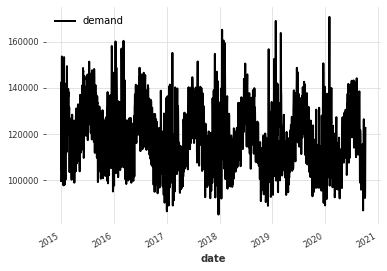

In [56]:
series.plot()
plt.show()

In [57]:
train, val = series.split_after(pd.Timestamp('20200101'))
scaler = Scaler()
train_transformed = scaler.fit_transform(train)
val_transformed = scaler.transform(val)
series_transformed = scaler.transform(series)

In [58]:
covariates = TimeSeries.from_dataframe(df,'date',['min_temperature' ,'max_temperature' ,'solar_exposure','rainfall' ,'school_day','holiday'],fill_missing_dates=True)

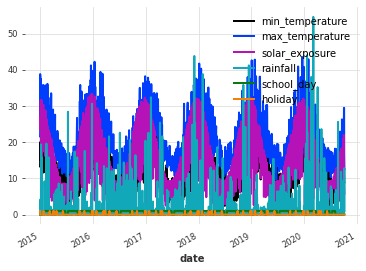

In [62]:
covariates.plot()

In [63]:
len(covariates)

2106

In [64]:
# create month and year covariate series
year_series = datetime_attribute_timeseries(pd.date_range(start=series.start_time(), freq=series.freq_str, periods=2106),
                                             attribute='year', one_hot=False)
year_series = Scaler().fit_transform(year_series)
month_series = datetime_attribute_timeseries(year_series, attribute='month', one_hot=True)
time_covariates = year_series.stack(month_series)

In [65]:
cov = time_covariates.stack(covariates)

In [66]:
scaler = Scaler()
train_cov, val_cov = cov.split_after(pd.Timestamp('20200101'))
train_cov_transformed = scaler.fit_transform(train_cov)
val_cov_transformed = scaler.transform(val_cov)
covariates_transformed = scaler.transform(cov)

In [67]:
my_model = RNNModel(
    model='LSTM',
    hidden_dim=20,
    dropout=0,
    batch_size=8,
    n_epochs=300,
    optimizer_kwargs={'lr': 1e-3},
    model_name='hdd',
    log_tensorboard=True,
    random_state=42,
    training_length=20,
    input_chunk_length=10,
    force_reset=True
)

In [71]:
my_model.fit(train_transformed,
             future_covariates=covariates_transformed, 
             verbose=True)

[2021-12-10 11:49:33,948] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1807 samples.
[2021-12-10 11:49:33,948] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1807 samples.
  2%|▏         | 6/300 [00:10<08:28,  1.73s/it]

  5%|▌         | 16/300 [00:27<08:08,  1.72s/it]

  9%|▊         | 26/300 [00:44<07:51,  1.72s/it]

 12%|█▏        | 36/300 [01:02<07:34,  1.72s/it]

 15%|█▌        | 46/300 [01:19<07:16,  1.72s/it]

 19%|█▊        | 56/300 [01:36<06:59,  1.72s/it]

 22%|██▏       | 66/300 [01:53<06:41,  1.72s/it]

 25%|██▌       | 76/300 [02:10<06:25,  1.72s/it]

 29%|██▊       | 86/300 [02:28<06:08,  1.72s/it]

 32%|███▏      | 96/300 [02:45<05:51,  1.72s/it]

 35%|███▌      | 106/300 [03:02<05:32,  1.71s/it]

 39%|███▊      | 116/300 [03:19<05:16,  1.72s/it]

 42%|████▏     | 126/300 [03:36<05:00,  1.73s/it]

 45%|████▌     | 136/300 [03:54<04:41,  1.72s/it]

 49%|████▊     | 146/300 [04:11<04:24,  1.72s/it]

 52%|█████▏    | 156/300 [04:28<04:08,  1.72s/it]

 55%|█████▌    | 166/300 [04:45<03:49,  1.71s/it]

 59%|█████▊    | 176/300 [05:02<03:33,  1.72s/it]

 62%|██████▏   | 186/300 [05:20<03:17,  1.73s/it]

 65%|██████▌   | 196/300 [05:37<02:59,  1.73s/it]

 69%|██████▊   | 206/300 [05:54<02:41,  1.71s/it]

 72%|███████▏  | 216/300 [06:11<02:24,  1.72s/it]

 75%|███████▌  | 226/300 [06:29<02:07,  1.72s/it]

 79%|███████▊  | 236/300 [06:46<01:49,  1.72s/it]

 82%|████████▏ | 246/300 [07:03<01:32,  1.72s/it]

 85%|████████▌ | 256/300 [07:20<01:15,  1.73s/it]

 89%|████████▊ | 266/300 [07:38<00:58,  1.72s/it]

 92%|█████████▏| 276/300 [07:55<00:41,  1.73s/it]

 95%|█████████▌| 286/300 [08:12<00:24,  1.72s/it]

 99%|█████████▊| 296/300 [08:29<00:06,  1.72s/it]

100%|██████████| 300/300 [08:36<00:00,  1.72s/it]


In [72]:
predicted = my_model.predict(n=len(val_transformed))

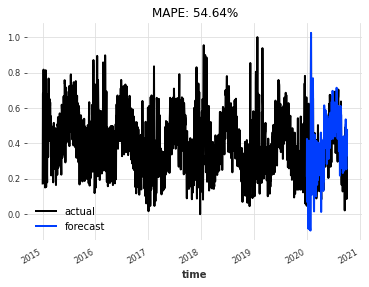

In [73]:
series_transformed.plot(label='actual')
predicted.plot(label='forecast')
plt.title('MAPE: {:.2f}%'.format(mape(predicted, val_transformed)))
plt.legend()
plt.show()